# Deep Hedging of Green PPAs

In [4]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from scipy.special import comb
import pandas as pd
import seaborn
import pprint
import deepdiff
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, LinearDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
from rivapy.models import OrnsteinUhlenbeck
from rivapy.pricing.green_ppa_pricing import GreenPPADeepHedgingPricer, DeepHedgeModel


import analysis

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Residual Demand Forward Model

In [2]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forward_expiries = [timegrid[-1]]

In [3]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=2.0, volatility=4.0)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=2.0, volatility=3.0)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

model = LinearDemandForwardModel(wind_power_forecast=wind, 
                                 x_volatility = 4.0 , 
                                 x_mean_reversion_speed = 0.1,
                                 power_name= 'Power_Germany')

In [7]:
np.random.seed(42)
rnd = np.random.normal(size=model.rnd_shape(n_sims=10_000, n_timesteps=timegrid.shape[0]))
paths = model.simulate(timegrid, rnd, expiries=forward_expiries, 
                                 initial_forecasts={'Onshore': [0.95],
                                                          'Offshore': [0.6]},
                                power_fwd_prices = [1.0])

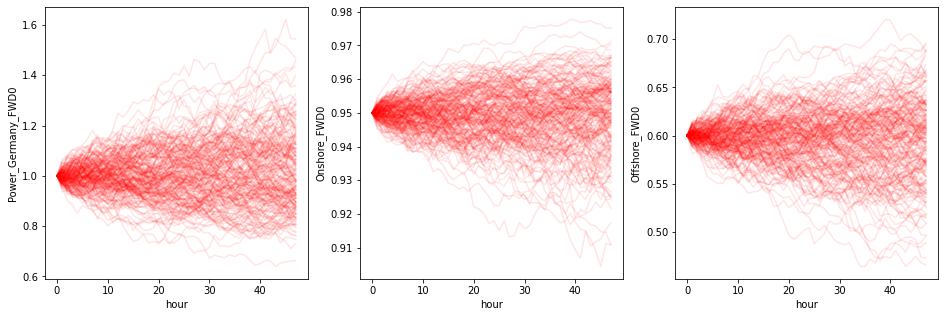

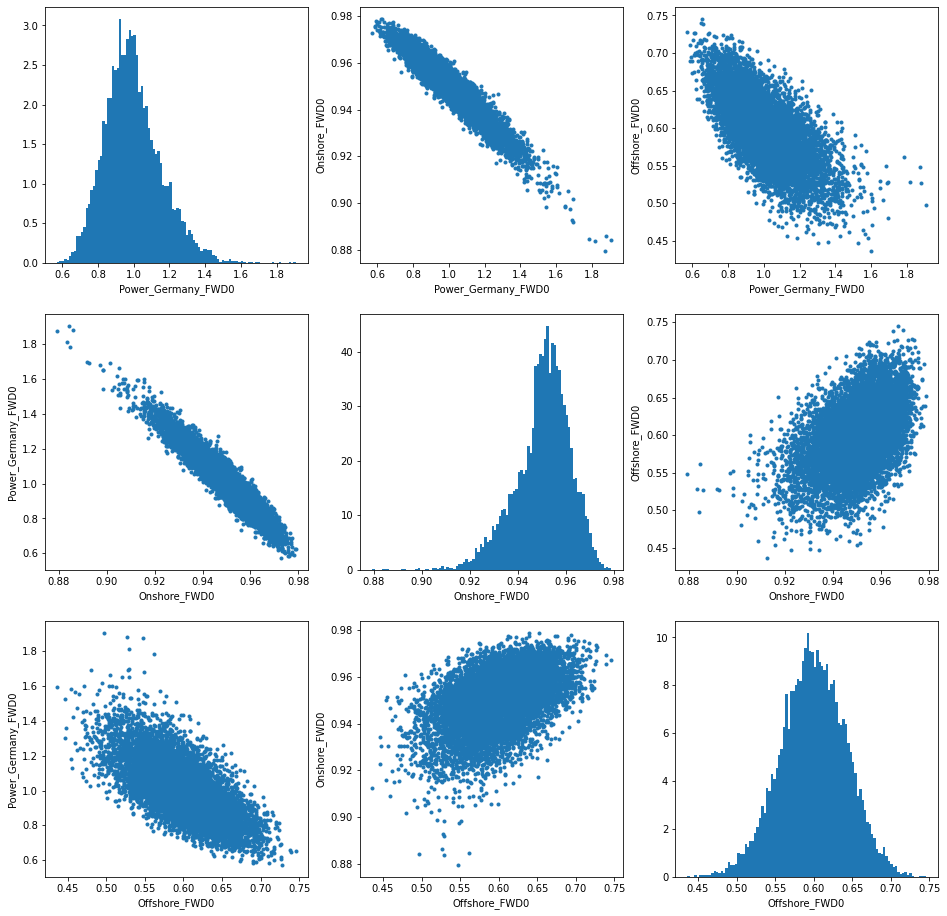

In [8]:
analysis.plot_paths(paths, None)

In [9]:
paths.get('Power_Germany_FWD0')[-1].mean()

0.9957418411935248

# Experiments

In [16]:
val_date = dt.datetime(2023,1,1)
strike = 1.0 #0.22
spec = GreenPPASpecification(udl='Power_Germany',
                            technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [10]:
repo = analysis.Repo('./experiments/')

In [8]:
repo.results.keys()

dict_keys([])

In [20]:
pricing_results = repo.run(val_date, 
                           spec, model, 
                           initial_forecasts={'Onshore': [0.8],
                                        'Offshore': [0.6]},
                           power_fwd_prices=[1.0],
                           forecast_hours=[10, 14, 18],
                           additional_states=['Offshore'],
                           depth=3, 
                           nb_neurons=64, 
                           n_sims=100_000, 
                           regularization=0.0,
                           epochs=1, verbose=1,
                           tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                           initial_lr=5e-4,
                           decay_steps=8_000,
                           batch_size=100, decay_rate=0.8, seed=42)

/home/doeltz/doeltz/development/RiVaPy/sandbox/green_ppa/../../rivapy/tools/datetime_grid.py:24: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  self.dates = pd.date_range(start, end, freq=freq, tz=tz, closed=closed).to_pydatetime()


3125/3125 [==============================] - 5s 1ms/step - loss: 2.0589e-05


2023-07-27 10:34:48.346564: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./experiments//2249948d0aadb13eb2d31acef838145b44f11b01//delta_model/assets


INFO:tensorflow:Assets written to: ./experiments//2249948d0aadb13eb2d31acef838145b44f11b01//delta_model/assets


# Analysis

In [5]:
repo = analysis.Repo('./experiments/')
# TODO: das muss wieder weg und in die serialisierung
for k,v in repo.results.items():
    v['val_date'] = dt.datetime.fromisoformat(v['val_date'])
    v['ppa_spec']['schedule'] = [dt.datetime.fromisoformat(k) for k in v['ppa_spec']['schedule']]

In [19]:
if False:
    to_delete = []
    for k,v in repo.results.items():
        if (v['pricing_param']['loss']=='exponential_utility') and (v['pricing_param']['regularization']>=100):
            to_delete.append(k)
    print('delete ',len(to_delete),'elements' )
    for d in to_delete:
        del repo.results[d]
    repo.save()

## HiPlot

In [6]:
repo.plot_hiplot()

<IPython.core.display.Javascript object>

In [7]:
if False:
    t1 = repo.results['d277eccaf811eecc8775716516f55f71634e68fa']#['pricing_param']#['power_fwd_prices'][0]#['model']
    t2 = repo.results['56071ff4ed5173b5d973d457908cfc0cdbfee617']
    ddiff = deepdiff.DeepDiff(t1,t2)
    pprint.pprint(ddiff)
    
#repo.results['d277eccaf811eecc8775716516f55f71634e68fa']

In [84]:
if True:
    experiments = {}
    # models with different regularization coefficients, n_forecast_hours = 3
    tmp = {
    'ref_keys': [ '3e614fd22e85a35d8060f6403e528b5776a692a7',
                 'cf6371ae0690b16fed4b3d3057a3b79314c48c9a',
                 '5d4f2fe9ea61863af8badfb2817d3918b0d6410b',
                   ],
        'labels': {'3e614fd22e85a35d8060f6403e528b5776a692a7': '0.0',
                   'cf6371ae0690b16fed4b3d3057a3b79314c48c9a': '0.2',
                   '5d4f2fe9ea61863af8badfb2817d3918b0d6410b': '0.5',
                   'b434e763fbdeebab9432ebe72f6920f46436cd40': 'utility, 10',
                   '03a8c1e2c7c3b21dc54f401faef65a7fe034568b': 'utility, 50'
                   
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18]',
    }
    experiments['varying_regularization']=tmp
    
    tmp = {
    'ref_keys': [ 'ca7f4aeb88d71908ad8fe6e9ebc16b096ca12af3',
                   'c2ec661955a56cc70bb037fe86fdeedd5d9bdb70',
                 'd6c174a31171957da8a4392d2911f3238f936144'
                   ],
    'labels': {'ca7f4aeb88d71908ad8fe6e9ebc16b096ca12af3': '0.0',
            'c2ec661955a56cc70bb037fe86fdeedd5d9bdb70': '0.2',
               'd6c174a31171957da8a4392d2911f3238f936144': '0.5'
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18] for ITM (power forward = 0.8)',
    }
    experiments['varying_regularization_ITM']=tmp
    
    tmp = {
    'ref_keys': [ '637976c7970c035afe479a7ca8ee9ebb2e041e71',
                   'e75d32a25a83a936140c58856fc5737675a04edc',
                 '61c60c47b5751b7a1887dc8edaea4bcc1b7f6ff0'
                   ],
    'labels': {'637976c7970c035afe479a7ca8ee9ebb2e041e71': '0.0',
            'e75d32a25a83a936140c58856fc5737675a04edc': '0.2',
               '61c60c47b5751b7a1887dc8edaea4bcc1b7f6ff0':'0.5'
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18] for OTM (power forward = 1.2)',
    }
    experiments['varying_regularization_OTM']=tmp
    
    tmp = {
    'ref_keys': [ '2e910288fdcc2dc2956a04a8195834aaf8ddfee0',
                   'ab2726e8bb416f71a2d0324d7e2b0ce37f1f0d98',
                 '3e614fd22e85a35d8060f6403e528b5776a692a7'
                   ],
    'labels': {'2e910288fdcc2dc2956a04a8195834aaf8ddfee0': '0.2',
            'ab2726e8bb416f71a2d0324d7e2b0ce37f1f0d98': '0.5',
               '3e614fd22e85a35d8060f6403e528b5776a692a7':'0.8'
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18] for OTM (power forward = 1.2)',
    }
    experiments['varying_forecast']=tmp
if False: 
    experiments = {}
    # models with different regularization coefficients, n_forecast_hours = 3
    tmp = {
    'ref_keys': [ 
                    'b4c462d6882475a84a754bb671780e9916c8d9ff',
                    'a816594ff6f8f489bb83feb919c9aa4626f1519f',
                    'bd7d72be86e9c12129568ce34e137dc1b5baaa51'
                   ],
        'labels': {'b4c462d6882475a84a754bb671780e9916c8d9ff': '0.0', 
                  'a816594ff6f8f489bb83feb919c9aa4626f1519f': '0.1', 
                  'bd7d72be86e9c12129568ce34e137dc1b5baaa51': '0.2', 
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18]',
    }
    experiments['varying_regularization']=tmp
    tmp = {
    'ref_keys': [ 
                    '8c00afe49241f09263678c80fab1c6bfc0435cfb',
                    '18e548c018e595b86c8d1f8832dbd0311fd742ef',
                    '4f379afb340619d3e5c532e8f3c04cc2584bbe4e',
                    '68e6fb620a2909dfa7875161128a0f59802be7fc'
                   ],
        'labels': {'8c00afe49241f09263678c80fab1c6bfc0435cfb': '0.0', 
                  '18e548c018e595b86c8d1f8832dbd0311fd742ef': '0.1', 
                  '4f379afb340619d3e5c532e8f3c04cc2584bbe4e': '0.2', 
                   '68e6fb620a2909dfa7875161128a0f59802be7fc' : 0.5
                  },
        'description':'varying regularization term for problem with three forecast hours [10,14,18] and a forecast of 0.5',
    }
    experiments['varying_regularization_forecast_0.5']=tmp
if False: #old stuff    
    experiments = {}
    # models with different regularization coefficients, n_forecast_hours = 3
    tmp = {
    'ref_keys': [ 
                    #'c977969a206844c4a79848df3db0ccd09bcd8ee7',
                     #'1aedf203216342f2dea183af9fcdda341e31337a', 
                    '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8',
                    'c679f5903b066db828d211ea1c48f03395f76d21', 
                    'e351f639d6c035c0a4cfeff4dd3ebd43d39f9932'
                   ],
        'labels': {'417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8': '0.0', 
                  '1aedf203216342f2dea183af9fcdda341e31337a': '0.1', 
                  'c977969a206844c4a79848df3db0ccd09bcd8ee7': '0.25', 
                  'c679f5903b066db828d211ea1c48f03395f76d21': '0.5', 
                  'e351f639d6c035c0a4cfeff4dd3ebd43d39f9932': '1.0'},
        'description':'varying regularization term for problem with three forecast hours [10,14,18]',
    }
    experiments['varying_regularization']=tmp
    experiments['zero_wind_volatility'] ={'ref_keys': ['489bf539cf645622b5a1fa29392a68e895b84f5b'], 
                                          'labels':{'489bf539cf645622b5a1fa29392a68e895b84f5b':'0.0'}, 
                                          'description':'zero wind wolatility (perfect replication by static hedge)'
                                         }

    experiments['strikes'] = { 'ref_keys': ['9c8b7a3a50ad27fc9be89c9324c074cebb86b4a9',  '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8', '1daab358760e5f2dbf34bc6600ba41ae02020493'],
                             'labels': {'9c8b7a3a50ad27fc9be89c9324c074cebb86b4a9':'0.9', 
                                      '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8':'1.0',
                                       '1daab358760e5f2dbf34bc6600ba41ae02020493': '1.1'},                          
                                  'description':'different strikes'     }

    experiments['forecasts'] ={'ref_keys':['7525471af6019d720fe596c36a689a8bcbaf6c3b', 
                                           '21b26f95807cefd400cd467b94b890f17e729395',
                                          '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8',
                                          '643e9896e2240d5815bbb9c9520215ae766a3447'], 
                               'labels':{'7525471af6019d720fe596c36a689a8bcbaf6c3b':'0.2', 
                                        '21b26f95807cefd400cd467b94b890f17e729395':'0.5',
                                        '417bfb85f4dba1ff37f76ff7d5fdb6ca2e0d2ea8':'0.8',
                                         '643e9896e2240d5815bbb9c9520215ae766a3447':'0.9'
                                        }}



In [85]:
experiment = 'varying_forecast' #'varying_regularization_forecast_0.5' #'varying_regularization' 
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
hedge_models = {k: repo.get_hedge_model(k) for k in ref_keys}
specs = {k: GreenPPASpecification.from_dict(repo.results[k]['ppa_spec']) for k in ref_keys}
result_dir = 'results/'+experiment+'/'

## Model paths

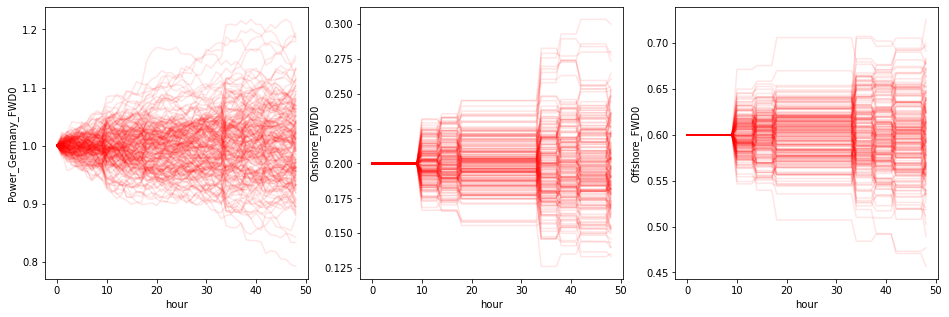

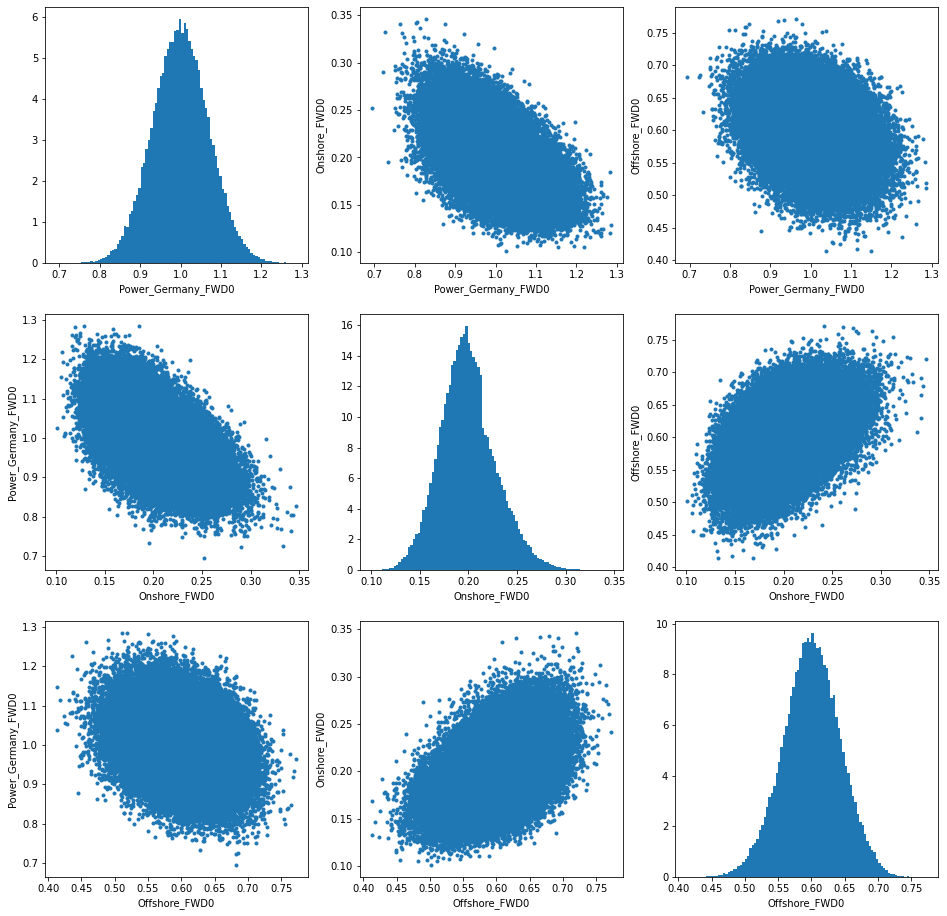

In [88]:
sim_results ={}
forecast_points={}
for k in ref_keys:
    sim_results[k], forecast_points[k] = repo.simulate_model(k, n_sims=100_000)
    
analysis.plot_paths(sim_results[ref_keys[0]], forecast_points[ref_keys[0]], result_dir)

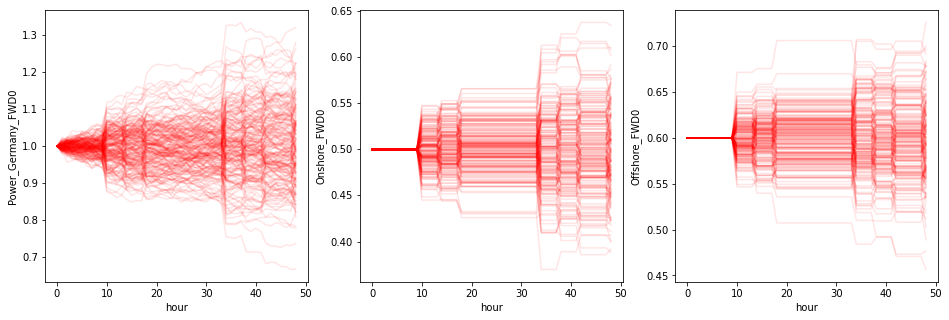

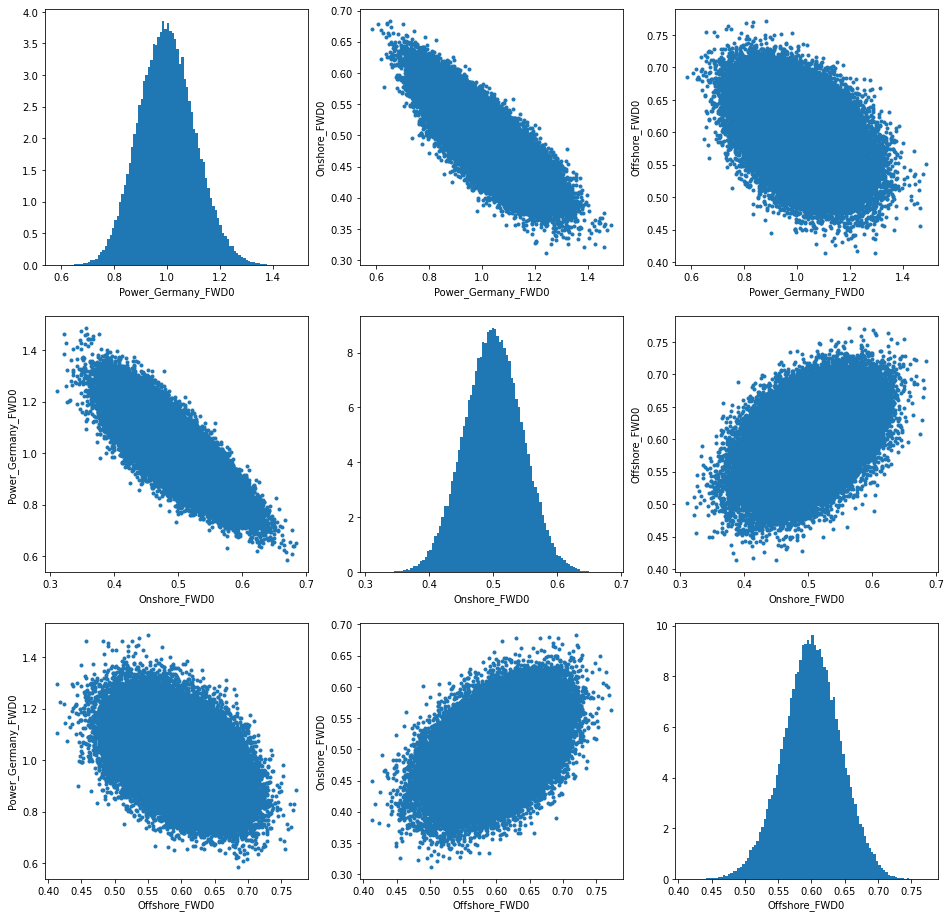

In [95]:
analysis.plot_paths(sim_results[ref_keys[1]], forecast_points[ref_keys[1]], result_dir)

## Hedge PnL

In [11]:
def compute_pnl(hedge_model, paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    print(green_ppa_spec.fixed_price)
    payoff = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])
    return hedge_model.compute_pnl(paths, payoff)

def compute_volume_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = volume[0,:]*power_price[0,:]
    for i in range(1,power_price.shape[0]-1):
        pnl += (volume[i,:]-volume[i-1,:])*power_price[i,:]
    pnl -= volume[-2,:]*power_price[-1,:]
    pnl += (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])
    return pnl

def compute_no_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])
    return pnl


def compute_static_volume_hedge_pnl(paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    pnl = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:]) + (-power_price[-1,:] +power_price[0,:])*(volume[0,:])
    return pnl

def compute_static_volume_hedge_var_pnl(paths, hedge_volume, green_ppa_spec, strike=None):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    strike_ = green_ppa_spec.fixed_price
    if strike is not None:
        strike_ = strike
    pnl = (power_price[-1,:] -strike_)*(volume[-1,:]) + (-power_price[-1,:] +power_price[0,:])*(hedge_volume)
    tmp = np.percentile(pnl, 5)
    return pnl[pnl<tmp].mean()#pnl.var()

In [89]:
paths = {k:{l:sim_results[k].get(l, forecast_points[k]) for l in ['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0']} for k in ref_keys}
pnl = {
    'volume_hedge': compute_volume_hedge_pnl(paths[ref_keys[0]], specs[ref_keys[0]]),
      'no_hedge': compute_no_hedge_pnl(paths[ref_keys[0]], specs[ref_keys[0]]),
    'static_volume_hedge':compute_static_volume_hedge_pnl(paths[ref_keys[0]], specs[ref_keys[0]])
      }
for k,v in hedge_models.items():
    paths[k]
    specs[k]
    labels[k]
    pnl[labels[k]] = compute_pnl(v, paths[k], specs[k])#specs['ec202973a34dfc5b71a86e0e7b2209a62c29b6a1'])#
#pnl['pnl_static_volume_hedge']= compute_static_volume_hedge_pnl(paths, spec)

1.0
1.0
1.0


In [124]:
if False:
    import tensorflow as tf
    model = hedge_models['24a19e98a0e338e6d0918ef48edcb1f4e00c0fd9']
    p=model._create_inputs(paths['24a19e98a0e338e6d0918ef48edcb1f4e00c0fd9'])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0)
    model.compile(optimizer, loss=model.custom_loss)
    model._loss='exponential_utility'
    model.evaluate(p, np.zeros(10_000))
    model._loss
    pred = model.predict(p)

In [15]:
#del pnl['pnl_static_volume_hedge']
#del pnl['1.0']
#del pnl['pnl_volume_hedge']

### Statistics

In [103]:
pnl_stat = {'name':[], 'mean': [], 'var':[],'p-skewness':[], '0.1%':[], '1%': [], '5%':[], '1% ES':[], '5% ES':[], '0.1% ES':[],
           'utility, 10.0': [], 'utility, 50.0': []}
for k,v in pnl.items():
    if (k == 'no_hedge') or( k == 'static_volume_hedge'):# or (k==): # 
        continue
    v_ = 100.0*v
    pnl_stat['name'].append(k)
    pnl_stat['mean'].append(np.mean(v_))
    pnl_stat['var'].append(np.sqrt(np.var(v_)))
    pnl_stat['p-skewness'].append( 3.0*(v_.mean()-np.median(v_))/v_.std())
    
    tmp = np.percentile(v_, 0.1)
    pnl_stat['0.1%'].append(tmp)
    tmp = v_[v_<tmp].mean()
    pnl_stat['0.1% ES'].append(tmp) 
    
    tmp = np.percentile(v_, 1)
    pnl_stat['1%'].append(tmp)
    tmp = v_[v_<tmp].mean()
    pnl_stat['1% ES'].append(tmp)
    tmp = np.percentile(v_, 5)
    pnl_stat['5%'].append(tmp)
    tmp = v_[v_<tmp].mean()
    pnl_stat['5% ES'].append(tmp)
    
    pnl_stat['utility, 10.0'].append(np.mean(np.exp(-10.0*v)))
    pnl_stat['utility, 50.0'].append( np.mean(np.exp(-50.0*v)))
    
pnl_stat = pd.DataFrame(pnl_stat)
pnl_stat#.to_latex(float_format="{:0.3f}".format)

,name,mean,var,p-skewness,0.1%,1%,5%,1% ES,5% ES,0.1% ES,"utility, 10.0","utility, 50.0"
0,volume_hedge,-0.104587,0.163699,-0.614351,-1.158867,-0.692581,-0.407910,-0.889317,-0.586257,-1.374197,1.010650,1.057424
1,0.2,-0.104920,0.136937,-0.279581,-0.854839,-0.531677,-0.337737,-0.670865,-0.460580,-1.002717,1.010642,1.056384
2,0.5,-0.390391,0.292786,-0.520382,-1.975582,-1.332763,-0.931786,-1.602591,-1.185866,-2.252038,1.040262,1.229544
3,0.8,-0.370539,0.265523,-0.574617,-1.886736,-1.245589,-0.864486,-1.522518,-1.107037,-2.264686,1.038120,1.215024


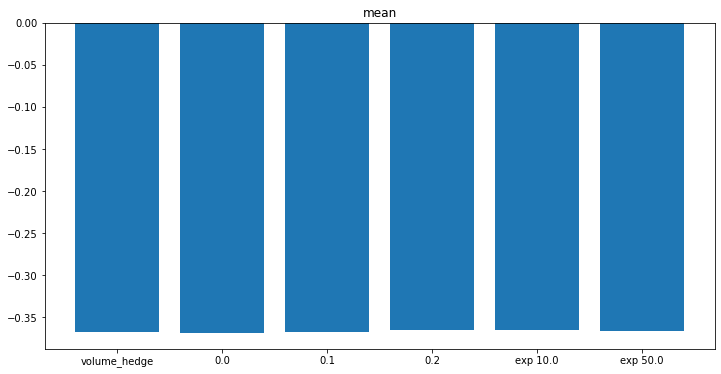

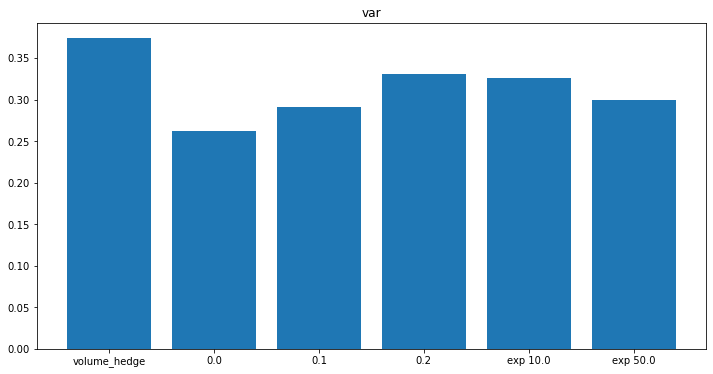

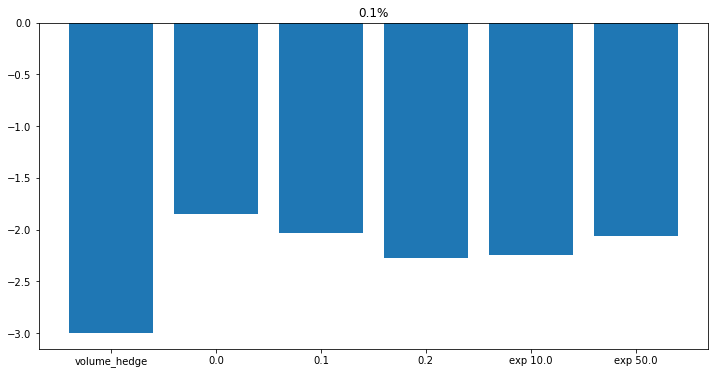

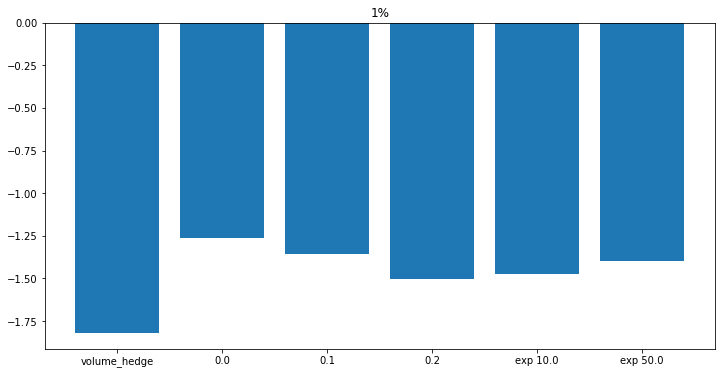

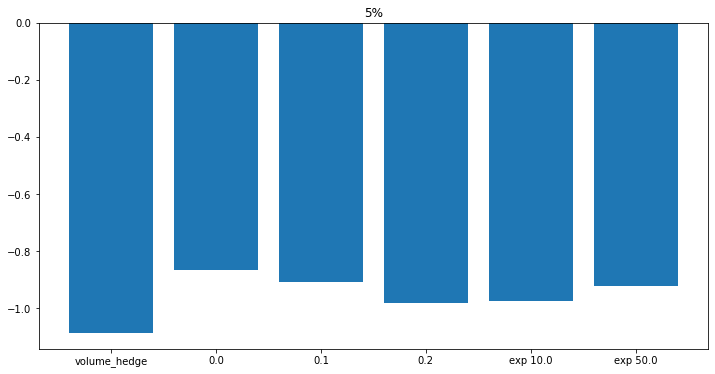

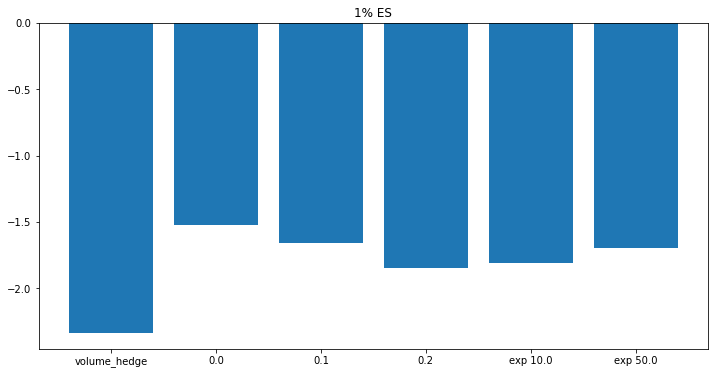

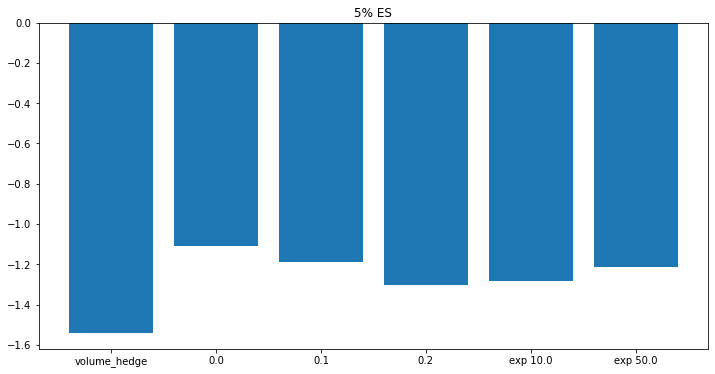

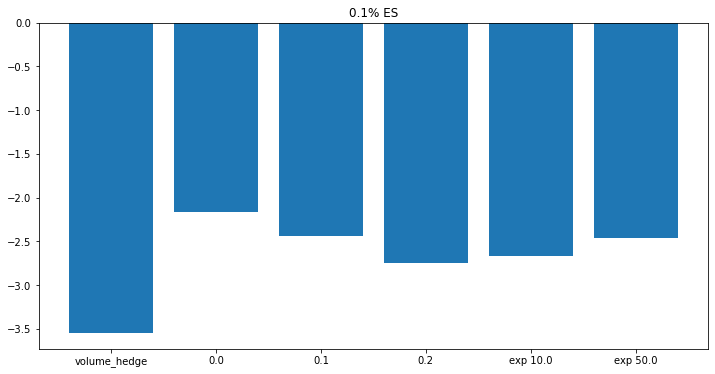

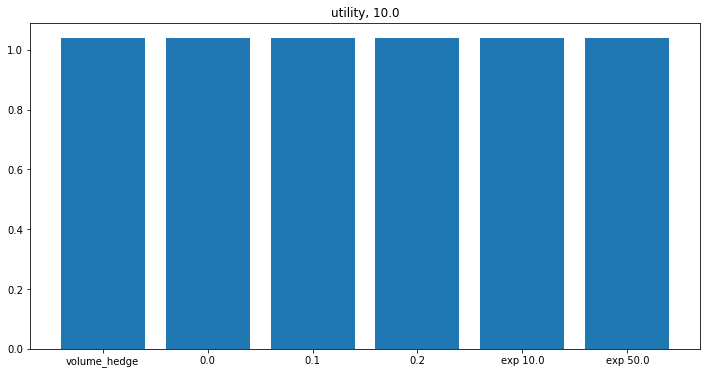

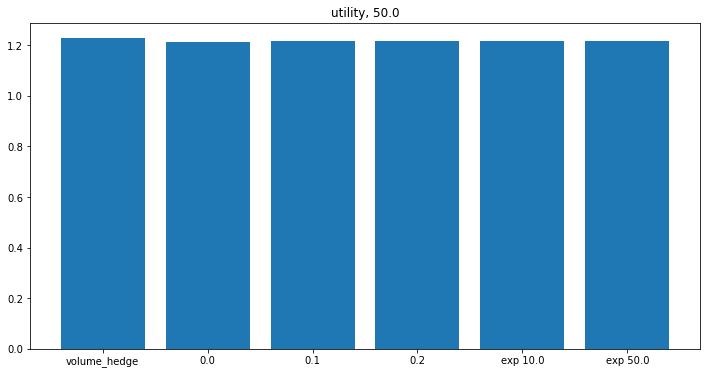

In [130]:
for k in pnl_stat.columns:
    if k == 'name':
        continue
    names = list(pnl_stat['name'])
    values = list(pnl_stat[k])
    plt.figure(figsize=(12,6))
    plt.title(k)
    plt.bar(range(len(names)), values, tick_label=names);

### Distribution

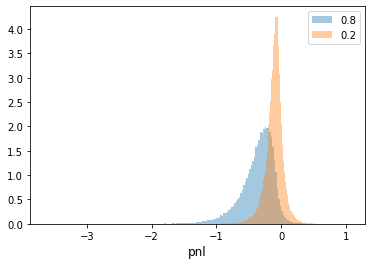

In [98]:
#plt.figure(figsize=(15,8))
alpha = 0.4#1.0/len(pnl)
#plt.hist(pnl_volume_hedge,bins=100, label='volume hedge', alpha=alpha, density=True)

order = []
for k,v in pnl.items():
    order.append((np.var(v),k))
    
order.sort(reverse=True)
order = [k[1] for k in order]
ignored = ['no_hedge', 
           'static_volume_hedge',
           'volume_hedge',
           #'0.2',
           '0.5',
           #'0.8',
           #'volume_hedge',
           #'0.1',
           #'0.2',
           'utility, 10',
           'utility, 50',
           #'0.0'
          ]
for k in order:
    if k in ignored:
        continue
    pnl_= pnl[k]#pnl[k] #np.clip(pnl[k], -0.005,0.005)
    plt.hist(100*pnl_,bins=200, label=k, alpha=alpha, density=True)#,  histtype='step')
plt.legend()
#plt.xlim(-3,2.0)
plt.xlabel('pnl', fontsize=12);
plt.savefig(result_dir+'pnl_distributions.png', dpi=400)

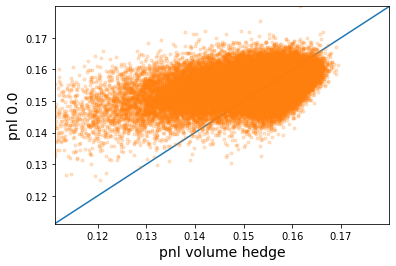

In [79]:
pnl_min = np.min(pnl['0.0'])
pnl_max = np.max(pnl['0.0'])

plt.plot([pnl_min,pnl_max], [pnl_min,pnl_max], '-')
plt.plot(pnl['volume_hedge'], pnl['0.0'],'.', alpha=0.2)

plt.xlim(pnl_min, pnl_max)
plt.ylim(pnl_min, pnl_max)
plt.xlabel('pnl volume hedge', fontsize=14)
plt.ylabel('pnl 0.0', fontsize=14);
plt.savefig(result_dir+'pnl_comparison_scatter.png', dpi=400)

### Dependencies

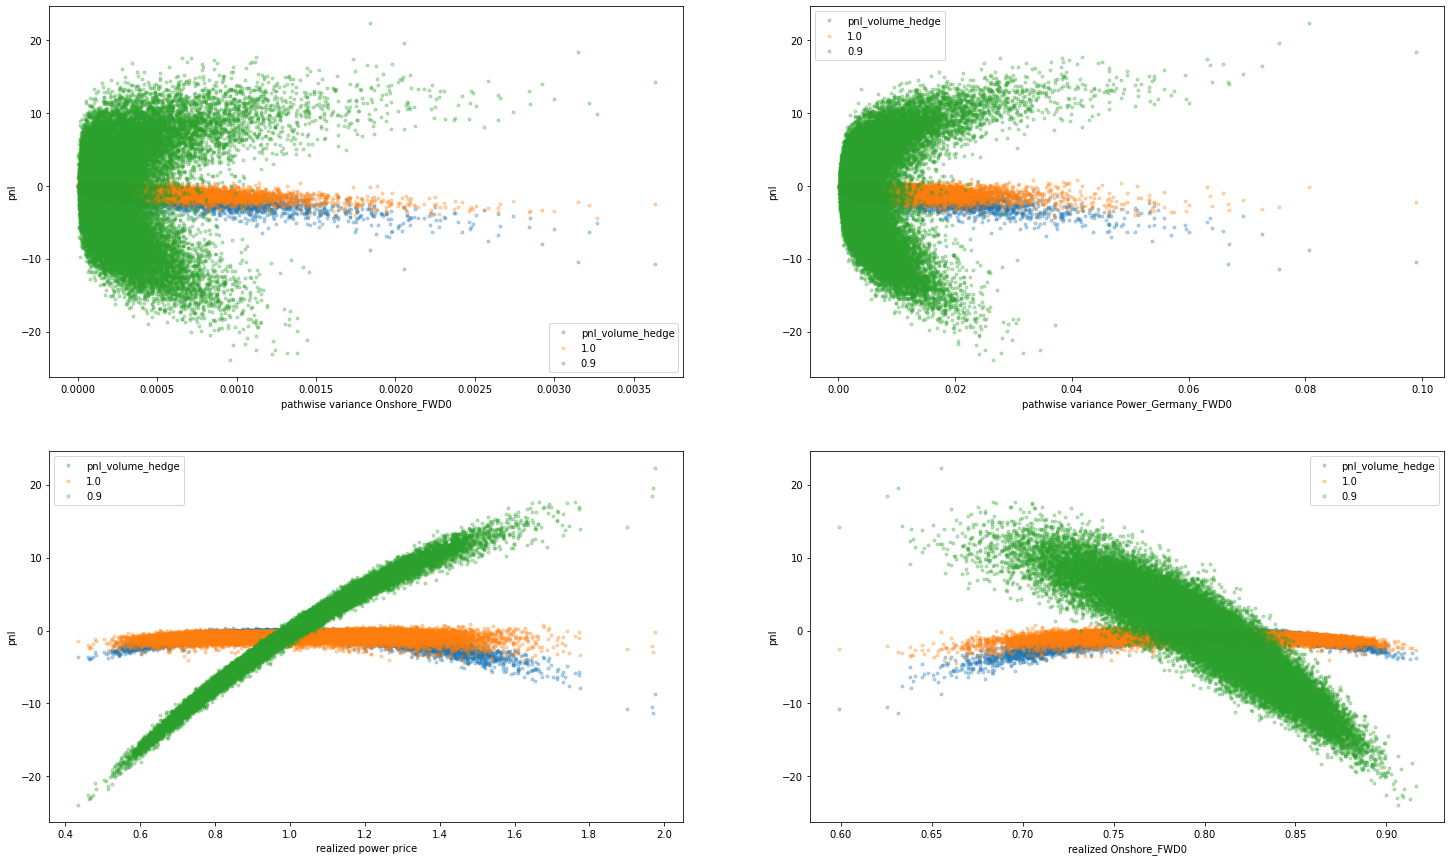

In [80]:
plt.figure(figsize=(25,15))

power_price = paths.get('Power_Germany_FWD0', None)
volume = paths.get(spec.location+'_FWD0')
volume_var = volume.var(axis=0)
plt.subplot(2,2,1)
#plt.hist(volume_var, bins=100, density=True);
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(volume_var, 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('pathwise variance Onshore_FWD0')

plt.subplot(2,2,2)
power_var = power_price.var(axis=0)
#plt.hist(volume_var, bins=100, density=True);
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(power_var, 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('pathwise variance Power_Germany_FWD0');

plt.subplot(2,2,3)
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(power_price[-1,:], 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('realized power price');

plt.subplot(2,2,4)
for k,v in pnl.items():
    if k == '0.5':
        continue
    plt.plot(volume[-1,:], 100.0*v, '.', alpha=0.3, label=k)
plt.legend()
plt.ylabel('pnl')
plt.xlabel('realized Onshore_FWD0');
plt.savefig(result_dir+'pnl_vs_paths.png', dpi=400)

In [15]:
hedge_models.items()

dict_items([('7525471af6019d720fe596c36a689a8bcbaf6c3b', <rivapy.pricing.deep_hedging.DeepHedgeModel object at 0x7f3992178d00>)])

## Delta Plots

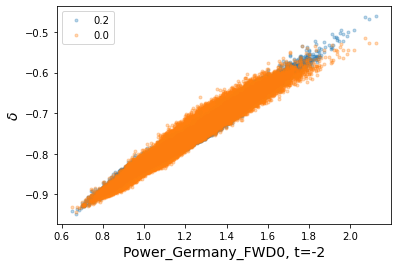

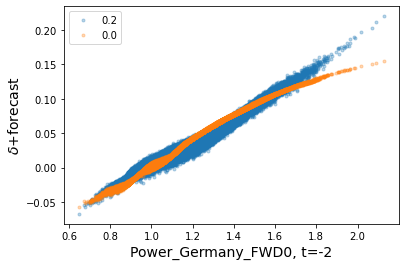

In [80]:
t = -2
n_x = 1
n_y = 3

#plt.figure(figsize=(24,8))
volume_hedge=-1.0*paths[ref_keys[0]]['Onshore_FWD0'][t,:]
for k in ['0.2',
          #'0.1',
          '0.0']:
    key = labels_T[k]
    hedge_model = hedge_models[key]

    #plt.figure(figsize=(24,8))
    #if labels[key] in ['1.0','0.5']:
    #    continue
    delta = hedge_model.compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Power_Germany_FWD0']
    plt.plot(v[t,:], delta,'.', label=labels[key], alpha=0.3)#+paths[key]['Onshore_FWD0'][t,:]
    plt.xlabel('Power_Germany_FWD0'+', t='+str(t), fontsize=14)
    plt.ylabel('$\delta$', fontsize=14)
plt.legend()
plt.savefig(result_dir+'delta_vs_power'+str(t)+'.png', dpi=400)
plt.figure()
for k in ['0.2',#'0.1',
          '0.0']:
    key = labels_T[k]
    hedge_model = hedge_models[key]

    #plt.figure(figsize=(24,8))
    #if labels[key] in ['1.0','0.5']:
    #    continue
    delta = hedge_model.compute_delta(paths[key], t).reshape((-1,))
    v = paths[key]['Power_Germany_FWD0']
    plt.plot(v[t,:], delta+paths[key]['Onshore_FWD0'][t,:],'.', label=labels[key], alpha=0.3)#
    plt.xlabel('Power_Germany_FWD0'+', t='+str(t), fontsize=14)
    plt.ylabel('$\delta$+forecast', fontsize=14)
plt.legend()
plt.savefig(result_dir+'delta_diff_vs_power'+str(t)+'.png', dpi=400);


In [17]:
if False:
    t = -2
    n_x = 1
    n_y = 3
    ignored = ['no_hedge', 
               'static_volume_hedge',
               '0.5',
               #'volume_hedge',
               '0.1',
               '0.2',
               'exp 10.0',
               'exp 50.0',
               #'0.0'
              ]
    #plt.figure(figsize=(24,8))
    volume_hedge=-1.0*paths[ref_keys[0]]['Onshore_FWD0'][t,:]
    plot_volume_hedge = True
    for key, hedge_model in hedge_models.items():
        if labels[key] in ignored:
            continue
        #plt.figure(figsize=(24,8))
        #if labels[key] in ['1.0','0.5']:
        #    continue
        delta = hedge_model.compute_delta(paths[key], t).reshape((-1,))
        i=1

        for k,v in paths[key].items():
            plt.figure()
            #plt.subplot(n_x, n_y, i)
            plt.plot(v[t,:], delta+paths[key]['Onshore_FWD0'][t,:],'.', label=labels[key], alpha=0.3)
            #if plot_volume_hedge and True:
            #    plt.plot(v[t,:], volume_hedge, '.', label='volume hedge', alpha=0.3)
            if k == 'Onshore_FWD0':
                plt.plot([0.6,0.95],[-0.6,-0.95])
            plt.xlabel(k+', t='+str(t))
            plt.ylabel('delta')
            plt.legend()
            i+= 1
        plot_volume_hedge = False

    plt.legend()
    #plt.savefig(result_dir+'delta_'+str(t)+'.png', dpi=400)
    if False:
        for k,v in paths.items():
            plt.subplot(n_x, n_y, i)
            plt.plot(v[t,:], v[-1,:],'.')
            plt.xlabel(k+', t='+str(t))
            plt.ylabel(k+', final')
            i+= 1

In [81]:
delta = {'volume hedge': -paths[ref_keys[0]].get('Onshore_FWD0')}
for key, hedge_model in hedge_models.items():
    d = hedge_model.compute_delta(paths[key])
    delta[labels[key]] = d.reshape((d.shape[0],-1))

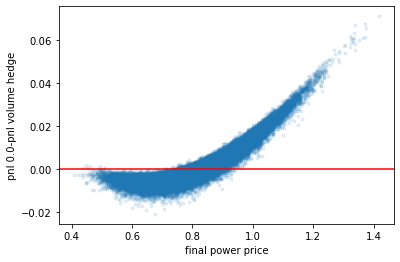

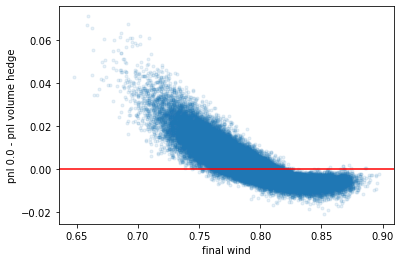

In [82]:
paths[ref_keys[0]].get('Power_Germany_FWD0')
pnl_diff = pnl['0.0'] - pnl['volume_hedge']
plt.plot(power[-1,:], pnl_diff, '.', alpha=0.1)
plt.xlabel('final power price')
plt.ylabel('pnl 0.0-pnl volume hedge')
plt.axhline(0.0, color='r')
plt.savefig(result_dir+'power_price_vs_pnl_dif'+str(t)+'.png', dpi=400);
plt.figure()
wind = paths[ref_keys[0]].get('Onshore_FWD0')
pnl_diff = pnl['0.0'] - pnl['volume_hedge']
plt.plot(wind[-1,:], pnl_diff, '.', alpha=0.1)
plt.xlabel('final wind')
plt.ylabel('pnl 0.0 - pnl volume hedge')
plt.axhline(0.0, color='r')
plt.savefig(result_dir+'wind_vs_pnl_dif'+str(t)+'.png', dpi=400);

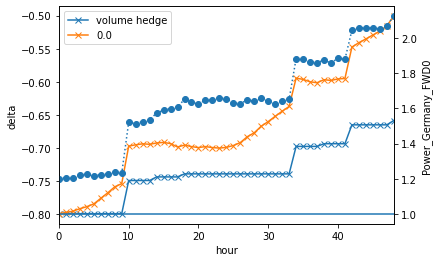

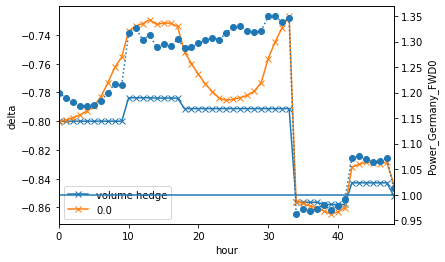

In [83]:
pnl_diff = pnl['0.0'] - pnl['volume_hedge']
n_paths = [(np.argmax(pnl_diff), 'max_pnl_diff'), (np.argmin(pnl_diff), 'min_pnl_diff')]
ignore = ['0.2', '0.5']
for n_path, n_path_name in n_paths:
    plt.figure()
    #plt.figure(figsize=(10,8))
    for k,v in delta.items():
        if k in ignore:
            continue
        plt.plot(v[:,n_path], '-x', label=k)
    plt.legend()  
    plt.ylabel('delta')
    plt.xlabel('hour'); 
    ax2 = plt.twinx() 
    power = paths[ref_keys[0]].get('Power_Germany_FWD0')
    ax2.plot(power[:,n_path],':o')
    ax2.set_ylabel('Power_Germany_FWD0')
    ax2.axhline(1.0)
    plt.xlim(0,48);
    plt.savefig(result_dir+'delta_path_'+n_path_name+'.png', dpi=400);

In [73]:
result_dir

'results/varying_regularization_ITM/'